In [114]:
import astropy.io.fits as fits
import numpy as np
from scipy.integrate import quad
import scipy.integrate as integrate
from scipy.optimize import curve_fit
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.table import Table, join
import os
import matplotlib.pyplot as plt
from astropy.cosmology import FlatLambdaCDM
import halomod as hm
import hmf
import treecorr

In [115]:
import DarkVerse as dv


In [116]:
%matplotlib inline
plt.rc('font',**{'family':'serif','size':14})
#plt.rc('text', usetex=True)


In [117]:
home_dir = os.path.expanduser('~')
directory_SN_X3 = "/home/astro/manasoi7/Master_Thesis/Results/SN-X3"
directory_SN_C3 = "/home/astro/manasoi7/Master_Thesis/Results/SN-C3"
directory_SN_E2 = "/home/astro/manasoi7/Master_Thesis/Results/SN-E2" 
directory_COSMOS = "/home/astro/manasoi7/Master_Thesis/Results/COSMOS" 
res = os.path.join(home_dir, 'Master_Thesis', 'Results')

# SN-C3

In [118]:

home_dir = os.path.expanduser('~')
thesis_path = os.path.join(home_dir, 'Master_Thesis', 'DATA')



# Catalog
fits_file_path = os.path.join(thesis_path, "DES_DF_SN-C3_sbi_output.fits")  #"Y3_deep_fields_DB_wKNN_cat_SN-C3_zm.fits"
t= Table.read(fits_file_path)
masked_file_path = os.path.join(thesis_path, "SN-C3_masked_cat.fits")  
t3= Table.read(masked_file_path)

# Join in one table

t=join(t,t3,keys='id') 
#t.rename_column('ra_1','ra')
#t.rename_column('dec_1','dec')
t.rename_column('mode_z','z')
t.rename_column('mode_mass','SM')

# Load Randoms
fits_random = os.path.join(thesis_path, "SN-C3_randoms_ugriz_trim_video.fits") 
t2 = Table.read(fits_random)
randoms = t2  # Random catalog

# Define Correlation Function Configuration
config = {
    'min_sep': 0.003, 
    'max_sep': 1.78,
    'bin_size': 0.1,
    'sep_units': 'degrees',
    'var_method': 'shot'   # if using the internal 'var_method': 'bootstrap' of treecrorr, but then it takes a long time to run
}







In [ ]:

z_min, z_max = 0.8, 1
SM_min, SM_max = 10, 12.5
    
sub1 = dv.Selection(t, randoms,z_min, z_max,SM_min, SM_max, config)    # if i put the upper limit at 12.5 logSM then it is considered open-ended

# Fit HOD with custom bounds
#hod_params, pcov = sub1.fit_hod()  #  p0=[12.5, 13.5, 1.0], bounds = ([11.0*1e-7, 12.5, 0.99], [14.5*1e-7, 15.5, 1.01]) # fix alpha to 1
hod_params, pcov = sub1.fit_hod(p0=[12.3*1e-7, 13.5, 1.0]) 


results = sub1.get_results()

logM_min, logM_1, alpha = results['hod_params']
print(f"HOD fit results: M_min = 10^{logM_min*1e7:.2f}, "
      f"M_1 = 10^{logM_1:.2f}, alpha = {alpha:.2f}")

In [ ]:
print(sub1.IC)  # should be around 0.017

In [ ]:
theta = results['theta']
w_obs = results['w_theta']
var_w_obs= results['var_w_theta_bootstrap']
w_err = np.sqrt(var_w_obs)
xi_m_values = results['xi_m']
xi_g_values = results['xi_g']

# Model prediction with best-fit parameters
w_model = sub1.hod_model(logM_min *1e7, logM_1, alpha) 
sub1.gg.hod_params = {"M_min": 1.2645478724590092e-06 *1e7 , "M_1": 14.02, "alpha": 1.89}


plt.figure(figsize=(10, 8))

plt.errorbar(theta, w_obs, yerr= w_err, fmt='o', label= 'SN-C3')
plt.plot(theta, w_model, label='Best-fit HOD Model', color='red')
#plt.plot(sub1.theta, sub1.gg.angular_corr_gal - sub1.IC, color='purple')

#plt.plot(theta, xi_m_values, label=r'$\w_{dm}(\theta)$ (Matter-Matter)', linestyle='dashed', color='black')
#plt.plot(theta, xi_g_values, label=r'(Galaxy-Galaxy) corr. function', linestyle='dashed', color='blueviolet')


plt.xscale('log')
plt.yscale('log')
#plt.ylim([1e-4,10.])

plt.xlabel('θ [degrees]', fontsize=12)
plt.ylabel('w(θ)', fontsize=12)
plt.title(f'$w(\\theta)$ of SN-C3 for $10^{{{SM_min}}} < M_* < 10^{{{SM_max}}}$, $z \in [{z_min},{z_max}]$', fontsize=14)

plt.legend(fontsize=10, framealpha=0.8)
plt.grid(True, which="both", ls="--", alpha=0.3)

# Add annotations
plt.text(0.2, 0.9, "1-halo region", transform=plt.gca().transAxes, color='gray')
plt.text(0.6, 0.9, "2-halo region", transform=plt.gca().transAxes, color='gray')

plt.savefig(f"wtheta_SN_C3_HOD_SM_{SM_min}_{SM_max}_{z_min}_{z_max}.png")

plt.tight_layout()
plt.show()



In [ ]:

results = sub1.get_results()

# Extract values
A = results['power_law_params'][0]
z_mean = (sub1.z_min + sub1.z_max) / 2
delta_z = sub1.z_max - sub1.z_min
delta = 0.8  # or compute from subsample stats





In [ ]:
# Create instance
analysis = dv.SubsampleAnalysis(delta=delta, A=A, z_mean=z_mean, delta_z=delta_z)

# Compute r₀
r0 = analysis.calculate_r0()

print(f"Comoving correlation length r₀ = {r0:.2f} Mpc/h")

In [107]:
# Define redshift and stellar mass bins
z_bins = [(0.6, 0.8), (0.8, 1.0)]
SM_bins = [(9.8, 10.5), (10.5, 11.0), (11.0, 12.5)]

# Storage for results
r0_results = []

# Loop over redshift and stellar mass bins
for z_min, z_max in z_bins:
    for SM_min, SM_max in SM_bins:
        print(f"Processing bin: z=({z_min}, {z_max}), logSM=({SM_min}, {SM_max})")

        try:
            # Create selection
            sub = dv.Selection(catalog=t, randoms=randoms,
                            z_min=z_min, z_max=z_max,
                            SM_min=SM_min, SM_max=SM_max,
                            config=config)
            
            # Fit HOD
            hod_params, _ = sub.fit_hod()
            results = sub.get_results()
            
            # Extract parameters for r0 calculation
            A = results['power_law_params'][0]
            z_mean = (z_min + z_max) / 2
            delta_z = z_max - z_min
            delta = 0.8  # or estimate from sample normalization
            
            # Compute r0
            analysis = dv.SubsampleAnalysis(delta=delta, A=A, z_mean=z_mean, delta_z=delta_z)
            r0 = analysis.calculate_r0()

            print(f"  → r₀ = {r0:.2f} Mpc/h")

            # Save result
            r0_results.append({
                'z_min': z_min,
                'z_max': z_max,
                'SM_min': SM_min,
                'SM_max': SM_max,
                'r0': r0,
                'N': results['N']
            })
        
        except Exception as e:
            print(f"  ⚠️ Failed for bin (z=({z_min}, {z_max}), logSM=({SM_min}, {SM_max})): {e}")



Processing bin: z=(0.6, 0.8), logSM=(9.8, 10.5)
  ⚠️ Failed for bin (z=(0.6, 0.8), logSM=(9.8, 10.5)): dr has tot=0.
Processing bin: z=(0.6, 0.8), logSM=(10.5, 11.0)
  ⚠️ Failed for bin (z=(0.6, 0.8), logSM=(10.5, 11.0)): dr has tot=0.
Processing bin: z=(0.6, 0.8), logSM=(11.0, 12.5)
  ⚠️ Failed for bin (z=(0.6, 0.8), logSM=(11.0, 12.5)): dr has tot=0.
Processing bin: z=(0.8, 1.0), logSM=(9.8, 10.5)
  ⚠️ Failed for bin (z=(0.8, 1.0), logSM=(9.8, 10.5)): dr has tot=0.
Processing bin: z=(0.8, 1.0), logSM=(10.5, 11.0)
  ⚠️ Failed for bin (z=(0.8, 1.0), logSM=(10.5, 11.0)): dr has tot=0.
Processing bin: z=(0.8, 1.0), logSM=(11.0, 12.5)
  ⚠️ Failed for bin (z=(0.8, 1.0), logSM=(11.0, 12.5)): dr has tot=0.


In [113]:

# Convert results to a DataFrame for easier filtering
import pandas as pd
df_r0 = pd.DataFrame(r0_results)

# Define unique stellar mass bins for color coding
sm_bins_labels = sorted(df_r0[['SM_min', 'SM_max']].drop_duplicates().values.tolist())

# Plot setup
plt.figure(figsize=(8, 6))

# Plot each stellar mass bin separately
for SM_min, SM_max in sm_bins_labels:

#for sm_min, sm_max in sm_bins_labels:
    mask = (df_r0['SM_min'] == sm_min) & (df_r0['SM_max'] == sm_max)
    df_bin = df_r0[mask]

    z_mean = 0.5 * (df_bin['z_min'] + df_bin['z_max'])

    label = f"logSM = {sm_min:.1f}-{sm_max:.1f}"
    plt.plot(z_mean, df_bin['r0'], marker='o', label=label)

# Customize plot
plt.xlabel("Redshift (z)", fontsize=13)
plt.ylabel(r"$r_0$ [Mpc/h]", fontsize=13)
plt.title(r"Correlation Length $r_0$ vs Redshift", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(title="Stellar Mass Bins", fontsize=10)
plt.tight_layout()

# Show the plot
plt.show()


KeyError: "None of [Index(['SM_min', 'SM_max'], dtype='object')] are in the [columns]"

In [104]:
z_bins = [
    (0.0, 0.2),
    (0.2, 0.4),
    (0.4, 0.6),
    (0.6, 0.8),
    (0.8, 1.0),
]

sm_thresholds = {
    (0.0, 0.2): [10.00],
    (0.2, 0.4): [ 10.00],
    (0.4, 0.6): [10.00],
    (0.6, 0.8): [10.00],
    (0.8, 1.0): [10.00],
}
r0_results = []

for z_bin in z_bins:
    z_min, z_max = z_bin
    thresholds = sm_thresholds.get(z_bin, [])

    # Turn thresholds into (min, max) bins
    SM_bins = [(thresholds[i], thresholds[i+1]) for i in range(len(thresholds) - 1)]

    for SM_min, SM_max in SM_bins:
        print(f"Processing bin: z=({z_min}, {z_max}), logSM=({SM_min}, {SM_max})")

        try:
            sub = dv.Selection(catalog=t, randoms=randoms,
                               z_min=z_min, z_max=z_max,
                               SM_min=SM_min, SM_max=SM_max,
                               config=config)
            
            hod_params, _ = sub.fit_hod()
            results = sub.get_results()

            A = results['power_law_params'][0]
            z_mean = (z_min + z_max) / 2
            delta_z = z_max - z_min
            delta = 0.8

            analysis = dv.SubsampleAnalysis(delta=delta, A=A, z_mean=z_mean, delta_z=delta_z)
            r0 = analysis.calculate_r0()

            print(f"  → r₀ = {r0:.2f} Mpc/h")

            r0_results.append({
                'z_min': z_min,
                'z_max': z_max,
                'SM_min': SM_min,
                'SM_max': SM_max,
                'r0': r0,
                'N': results['N']
            })

        except Exception as e:
            print(f"  ⚠️ Failed for bin (z=({z_min}, {z_max}), logSM=({SM_min}, {SM_max})): {e}")


In [102]:

# Convert results to a DataFrame for easier filtering
import pandas as pd
df_r0 = pd.DataFrame(r0_results)

# Define unique stellar mass bins for color coding
sm_bins_labels = sorted(df_r0[['SM_min', 'SM_max']].drop_duplicates().values.tolist())

# Plot setup
plt.figure(figsize=(8, 6))

# Plot each stellar mass bin separately
for sm_min, sm_max in sm_bins_labels:
    mask = (df_r0['SM_min'] == sm_min) & (df_r0['SM_max'] == sm_max)
    df_bin = df_r0[mask]

    z_mean = 0.5 * (df_bin['z_min'] + df_bin['z_max'])

    label = f"logSM = {sm_min:.1f}-{sm_max:.1f}"
    plt.plot(z_mean, df_bin['r0'], marker='o', label=label)

# Customize plot
plt.xlabel("Redshift (z)", fontsize=13)
plt.ylabel(r"$r_0$ [Mpc/h]", fontsize=13)
plt.title(r"Correlation Length $r_0$ vs Redshift", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(title="Stellar Mass Bins", fontsize=10)
plt.tight_layout()

# Show the plot
plt.show()

KeyError: "None of [Index(['SM_min', 'SM_max'], dtype='object')] are in the [columns]"

## Put very tights bounds on alpha to basically make it fixed at 1

In [37]:
hod_params, pcov = sub1.fit_hod(p0=[12.59*1e-7, 13.97, 1.], bounds=([11.0*1e-7, 13., 0.99], [14.5*1e-7, 15.5, 1.01]))




In [38]:
results = sub1.get_results()

logM_min, logM_1, alpha = results['hod_params']
print(f"HOD fit results: M_min = 10^{logM_min*1e7:.2f}, "
      f"M_1 = 10^{logM_1:.2f}, alpha = {alpha:.2f}")

HOD fit results: M_min = 10^12.97, M_1 = 10^14.87, alpha = 1.01


In [39]:
sub1.hod_params

# 9.8 -> 12.8077
# 10.2 -> 12.8757
# 10.6 -> 12.9788
# 11. -> 13.1452

array([1.29679466e-06, 1.48677547e+01, 1.00999998e+00])

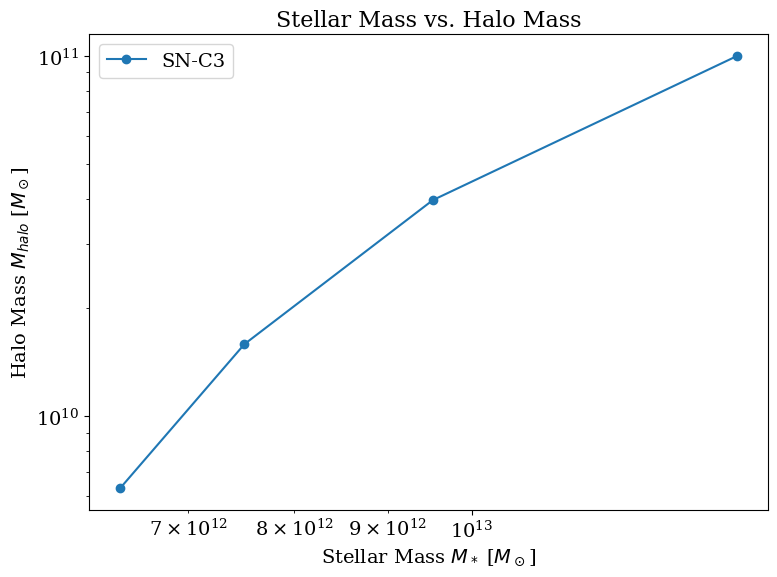

In [40]:

stellar_log = np.array([9.8, 10.2, 10.6, 11.0])
halo_log = np.array([12.8077, 12.8757, 12.9788, 13.1452])

# Convert to linear scale for log-log plot
stellar_mass = 10 ** stellar_log
halo_mass = 10 ** halo_log

# Plot
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(halo_mass,stellar_mass , 'o-', color='tab:blue', label= 'SN-C3')

# Labels and scales
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Stellar Mass $M_*$ [$M_\\odot$]', fontsize=14)
ax.set_ylabel('Halo Mass $M_{halo}$ [$M_\\odot$]', fontsize=14)
ax.set_title('Stellar Mass vs. Halo Mass', fontsize=16)
#ax.grid(True, which='both', ls='--', alpha=0.5)
ax.legend()

plt.tight_layout()
plt.savefig("stellar_vs_halo_mass_plot.png", dpi=300)
plt.show()


In [41]:
sub1.IC  # should be around 0.017

0.019550414203608295

<>:29: SyntaxWarning: invalid escape sequence '\i'
<>:29: SyntaxWarning: invalid escape sequence '\i'
/tmp/ipykernel_1369813/4116110242.py:29: SyntaxWarning: invalid escape sequence '\i'
  plt.title(f'$w(\\theta)$ of SN-C3 for $10^{{{SM_min}}} < M_* < 10^{{{SM_max}}}$, $z \in [{z_min},{z_max}]$', fontsize=14)


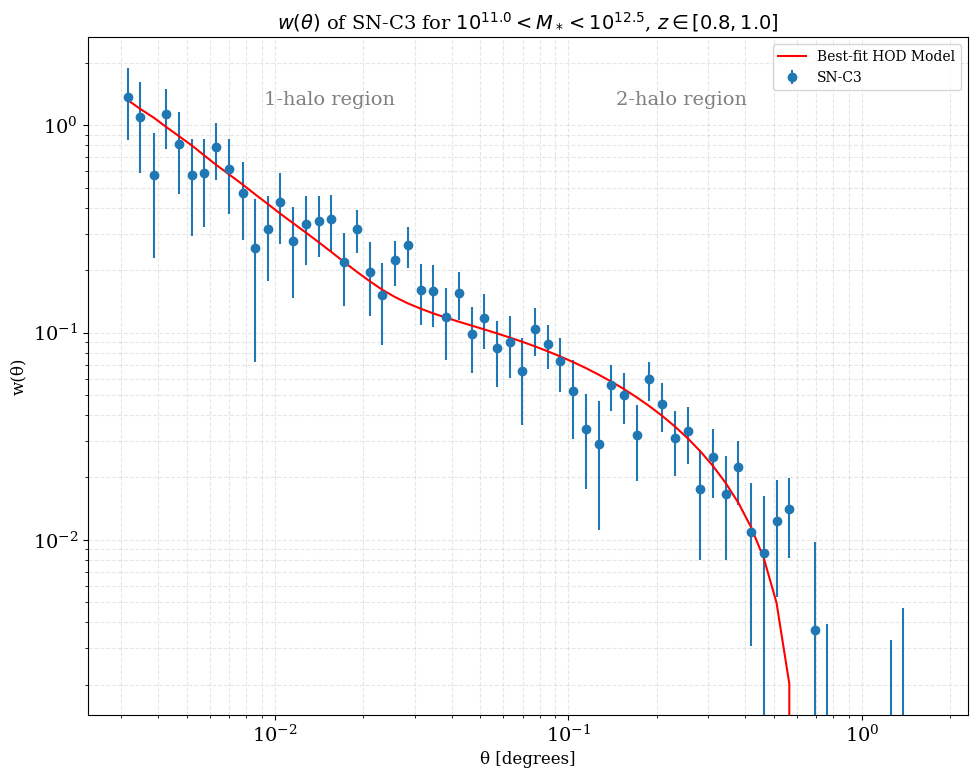

In [42]:
theta = results['theta']
w_obs = results['w_theta']
var_w_obs= results['var_w_theta_bootstrap']
w_err = np.sqrt(var_w_obs)
xi_m_values = results['xi_m']

# Model prediction with best-fit parameters
#logM_min, logM_1, alpha = results['hod_params']
w_model = sub1.hod_model(logM_min *1e7, logM_1, alpha) 
#w_model = sub1.hod_model(*hod_params)
sub1.gg.hod_params = {"M_min": 1.2645478724590092e-06 *1e7 , "M_1": 14.02, "alpha": 1.89}


plt.figure(figsize=(10, 8))

plt.errorbar(theta, w_obs, yerr= w_err, fmt='o', label= 'SN-C3')
plt.plot(theta, w_model, label='Best-fit HOD Model', color='red')
#plt.plot(sub1.theta, sub1.gg.angular_corr_gal - sub1.IC, color='purple')

#plt.plot(theta, xi_m_values, label=r'$\w_{dm}(\theta)$ (Matter-Matter)', linestyle='dashed', color='black')


plt.xscale('log')
plt.yscale('log')
#plt.ylim([1e-4,10.])

plt.xlabel('θ [degrees]', fontsize=12)
plt.ylabel('w(θ)', fontsize=12)
plt.title(f'$w(\\theta)$ of SN-C3 for $10^{{{SM_min}}} < M_* < 10^{{{SM_max}}}$, $z \in [{z_min},{z_max}]$', fontsize=14)

plt.legend(fontsize=10, framealpha=0.8)
plt.grid(True, which="both", ls="--", alpha=0.3)

# Add annotations
plt.text(0.2, 0.9, "1-halo region", transform=plt.gca().transAxes, color='gray')
plt.text(0.6, 0.9, "2-halo region", transform=plt.gca().transAxes, color='gray')


plt.tight_layout()
plt.show()


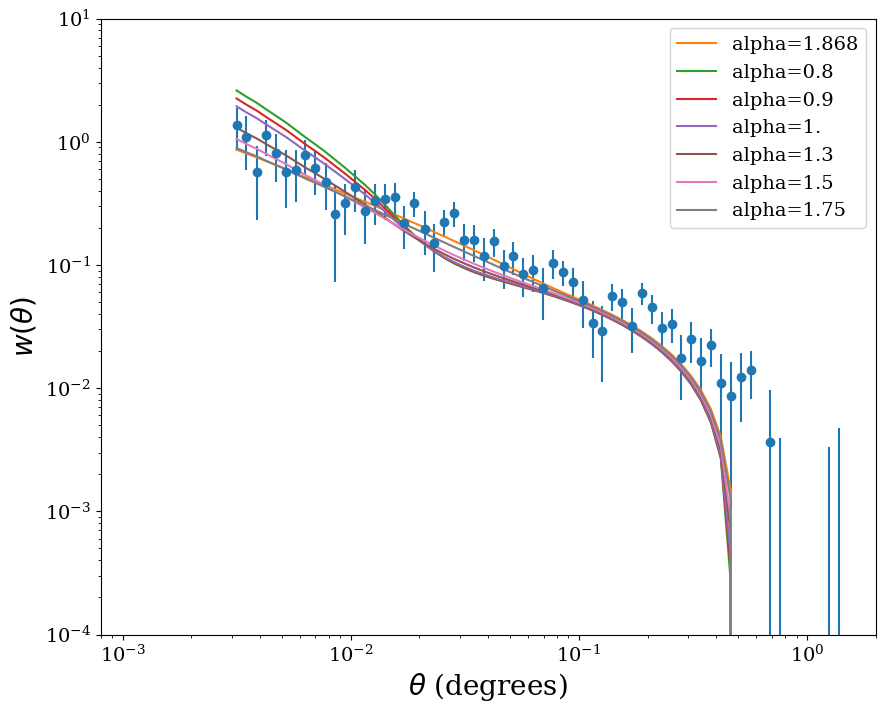

In [43]:
sub1.gg.hod_params = {"M_min": 12.6092998, "M_1": 13.9978, "alpha": 1.868}
#sub1.gg.update()

fig = plt.figure(figsize=[10,8])
ax = fig.add_subplot(111)
ax.errorbar(sub1.theta, sub1.w_theta, yerr=np.sqrt(sub1.var_w_theta_bootstrap), fmt='o')
ax.plot(sub1.theta, sub1.gg.angular_corr_gal-sub1.IC, '-', label='alpha=1.868')

sub1.gg.hod_params = {"alpha": 0.8}
#sub1.gg.update()
ax.plot(sub1.theta, sub1.gg.angular_corr_gal-sub1.IC, '-', label='alpha=0.8')


sub1.gg.hod_params = {"alpha": 0.9}
#sub1.gg.update()
ax.plot(sub1.theta, sub1.gg.angular_corr_gal-sub1.IC, '-', label='alpha=0.9')




sub1.gg.hod_params = {"alpha": 1.}
#sub1.gg.update()
ax.plot(sub1.theta, sub1.gg.angular_corr_gal-sub1.IC, '-', label='alpha=1.')

sub1.gg.hod_params = {"alpha": 1.3}
#sub1.gg.update()
ax.plot(sub1.theta, sub1.gg.angular_corr_gal-sub1.IC, '-', label='alpha=1.3')

sub1.gg.hod_params = {"alpha": 1.5}
#sub1.gg.update()
ax.plot(sub1.theta, sub1.gg.angular_corr_gal-sub1.IC, '-', label='alpha=1.5')

sub1.gg.hod_params = {"alpha": 1.75}
#sub1.gg.update()
ax.plot(sub1.theta, sub1.gg.angular_corr_gal-sub1.IC, '-', label='alpha=1.75')

ax.set_xlabel(r'$\theta$ (degrees)', fontsize=20)
ax.set_ylabel(r'$w(\theta)$', fontsize=20)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim([1e-4,10.])
ax.set_xlim([8e-4,2.])
ax.legend()
plt.savefig("acf_diff_alpha.png", dpi=300)

plt.show()

## Now trying all my fields and different redshift bins using Selection class that finds the best fit for my 3 HOD parameters

In [53]:
home_dir = os.path.expanduser('~')
thesis_path = os.path.join(home_dir, 'Master_Thesis', 'DATA')

# Field details
fields = {
    "SN-X3": {
        "catalog": "Y3_deep_fields_DB_wKNN_cat_SN-X3_zm.fits",
        "masked": "SN-X3_masked_cat.fits",
        "randoms": "SN-X3_randoms_ugriz_trim_video.fits"
    },
    "SN-C3": {
        "catalog": "Y3_deep_fields_DB_wKNN_cat_SN-C3_zm.fits",
        "masked": "SN-C3_masked_cat.fits",
        "randoms": "SN-C3_randoms_ugriz_trim_video.fits"
    },
    "SN-E2": {
        "catalog": "Y3_deep_fields_DB_wKNN_cat_SN-E2_zm.fits",
        "masked": "SN-E2_masked_cat.fits",
        "randoms": "SN-E2_randoms_ugriz_trim_video.fits"
    },
    "COSMOS": {
        "catalog": "Y3_deep_fields_DB_wKNN_cat_COSMOS_zm.fits",
        "masked": "COSMOS_masked_cat.fits",
        "randoms": "COSMOS_randoms_ugriz_trim_video.fits"
    }
}

config = {
    'min_sep': 0.003, 
    'max_sep': 1.78, 
    'nbins': 10,
    #'bin_size': 0.1,
    'sep_units': 'degrees',
    'var_method': 'shot'   # if using the internal 'var_method': 'bootstrap' of treecrorr, but then it takes a long time to run
}

# Fixed redshift range
z_min, z_max = 0.2, 0.5

# Define stellar mass bins
SM_bins = [(8.6, 9.0), (9.0, 9.6), (9.6, 10.5), (10.5, 12.5)]
colors = ["blue", "green", "red", "purple", "orange"]

# Initialize storage
all_results = {sm_range: {} for sm_range in SM_bins}

# Process each stellar mass bin
for SM_min, SM_max in SM_bins:
    print(f"\n\n🔹 Processing stellar mass bin {SM_min}–{SM_max}")
    
    # Initialize bias estimator with the first field
    first_field = list(fields.keys())[0]
    first_catalog = Table.read(os.path.join(thesis_path, fields[first_field]["catalog"]))
    first_masked = Table.read(os.path.join(thesis_path, fields[first_field]["masked"]))
    first_catalog = join(first_catalog, first_masked, keys='id')
    first_catalog.rename_columns(['ra_1', 'dec_1'], ['ra', 'dec'])
    first_randoms = Table.read(os.path.join(thesis_path, fields[first_field]["randoms"]))
    
    first_subsample = dv.Selection(
        catalog=first_catalog,
        randoms=first_randoms,
        z_min=z_min,
        z_max=z_max,
        SM_min=SM_min,
        SM_max=SM_max,
        config=config
    )
    first_results = first_subsample.get_results()
    
    estimator = dv.FieldBiasEstimator(
        xi_m=np.array(first_results['xi_m']),
        mask=(np.array(first_results['theta']) >= 0.1) & (np.array(first_results['theta']) <= 0.4)
    )
    
    bias_eff_dict = {}

    for field, paths in fields.items():
        print(f"\n🔸 Processing field: {field}")
        
        catalog = Table.read(os.path.join(thesis_path, paths["catalog"]))
        masked = Table.read(os.path.join(thesis_path, paths["masked"]))
        catalog = join(catalog, masked, keys='id')
        catalog.rename_columns(['ra_1', 'dec_1'], ['ra', 'dec'])
        randoms = Table.read(os.path.join(thesis_path, paths["randoms"]))
        
        subsample = dv.Selection(
            catalog=catalog,
            randoms=randoms,
            z_min=z_min,
            z_max=z_max,
            SM_min=SM_min,
            SM_max=SM_max,
            config=config
        )

        hod_params, pcov = subsample.fit_hod()

        results = subsample.get_results()
        
        bias_eff = subsample.gg.bias_effective_tracer
        bias_eff_dict[field] = bias_eff
        print(f"  ➤ bias_eff = {bias_eff:.3f}")

        logM_min, logM_1, alpha = results['hod_params']
        print(f"HOD fit results: M_min = 10^{logM_min*1e7:.2f}, "
              f"M_1 = 10^{logM_1:.2f}, alpha = {alpha:.2f}")
        
        estimator.add_field(
            field_name=field,
            xi_g=np.array(results['xi_g']),
            w_theta=np.array(results['w_theta']),
            w_theta_error=np.sqrt(np.array(results['var_w_theta_bootstrap'])),
            sum_rr=np.array(results['rr_counts'])
        )
    
    print("\nIndividual Field Results:")
    individual_results = estimator.fit_individual_fields()
    for name, b, be, ic in individual_results:
        print(f"{name}: b = {b:.3f} ± {be:.3f}, IC = {ic:.4f}")
    
    global_b, global_be = estimator.fit_combined()
    print(f"\nGlobal bias estimate: {global_b:.3f} ± {global_be:.3f}")
    
    all_results[(SM_min, SM_max)] = {
        'individual': individual_results,
        'global_b': global_b,
        'global_be': global_be,
        'estimator': estimator,
        'bias_eff': bias_eff_dict
    }




🔹 Processing stellar mass bin 8.6–9.0


/home/astro/manasoi7/.conda/envs/project/lib/python3.12/site-packages/hmf/density_field/transfer_models.py:233: UserWarning: 'extrapolate_with_eh' was not set. Defaulting to True, which is different behaviour than versions <=3.4.4. This warning may be removed in v4.0. Silence it by setting extrapolate_with_eh explicitly.
  warnings.warn(
/home/astro/manasoi7/.conda/envs/project/lib/python3.12/site-packages/halomod/halo_model.py:784: UserWarning: You are using an un-normalized mass function and bias function pair.Bias Tinker10 has the following paired HMF model: (). Matter correlations are not well-defined.
  tools.norm_warn(self)



🔸 Processing field: SN-X3
  ➤ bias_eff = 0.849
HOD fit results: M_min = 10^11.00, M_1 = 10^13.67, alpha = 0.35

🔸 Processing field: SN-C3
  ➤ bias_eff = 0.967
HOD fit results: M_min = 10^11.01, M_1 = 10^13.16, alpha = 1.55

🔸 Processing field: SN-E2
  ➤ bias_eff = 1.035
HOD fit results: M_min = 10^11.79, M_1 = 10^15.50, alpha = 2.00

🔸 Processing field: COSMOS
  ➤ bias_eff = 0.842
HOD fit results: M_min = 10^11.00, M_1 = 10^14.50, alpha = 0.48

Individual Field Results:
SN-X3: b = 1.144 ± 0.070, IC = 0.0137
SN-C3: b = 1.162 ± 0.054, IC = 0.0133
SN-E2: b = 1.346 ± 0.108, IC = 0.0186
COSMOS: b = 1.306 ± 0.117, IC = 0.0200

Global bias estimate: 1.007 ± 0.052


🔹 Processing stellar mass bin 9.0–9.6

🔸 Processing field: SN-X3
The following patch numbers have no objects: {21}
This may be a problem depending on your use case.
  ➤ bias_eff = 0.871
HOD fit results: M_min = 10^11.03, M_1 = 10^12.51, alpha = 0.38

🔸 Processing field: SN-C3
  ➤ bias_eff = 0.951
HOD fit results: M_min = 10^11.07,

<>:20: SyntaxWarning: invalid escape sequence '\i'
<>:20: SyntaxWarning: invalid escape sequence '\i'
/tmp/ipykernel_1369813/686828498.py:20: SyntaxWarning: invalid escape sequence '\i'
  ax.set_title(f'$w(\\theta)$ for $10^{{{SM_min}}} < M_* < 10^{{{SM_max}}}$, $z \in [{z_min},{z_max}]$', fontsize=14)


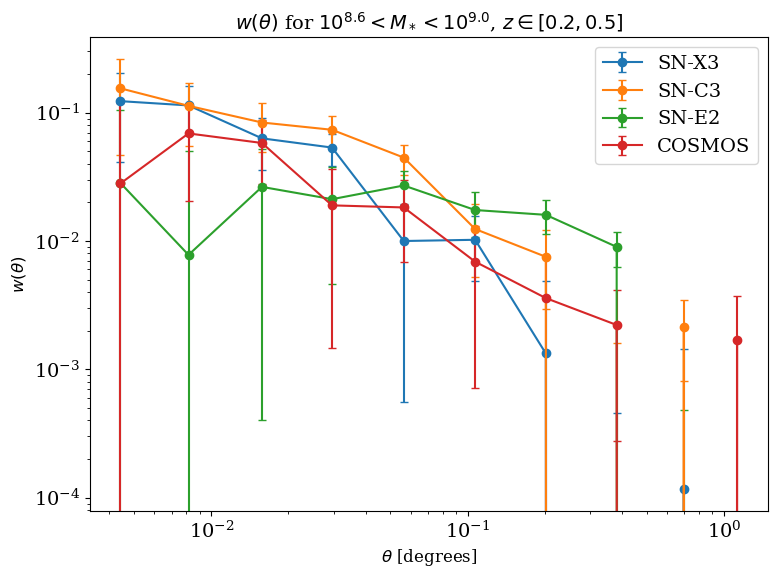

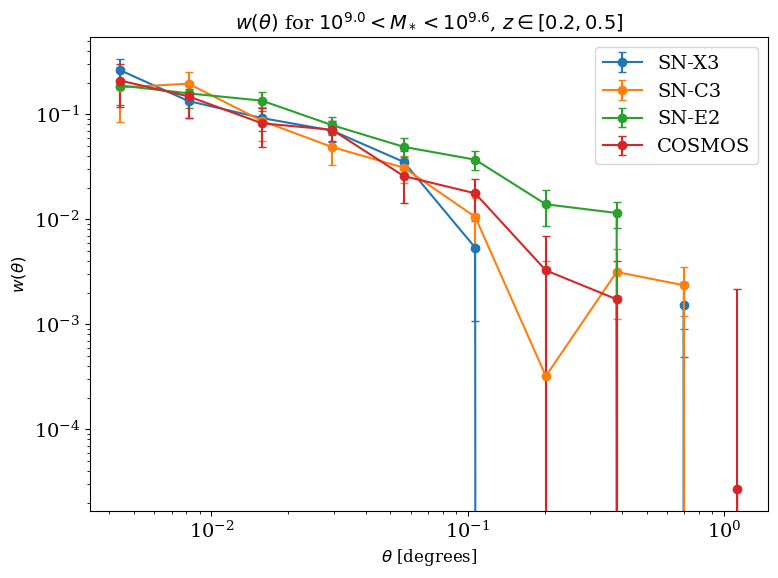

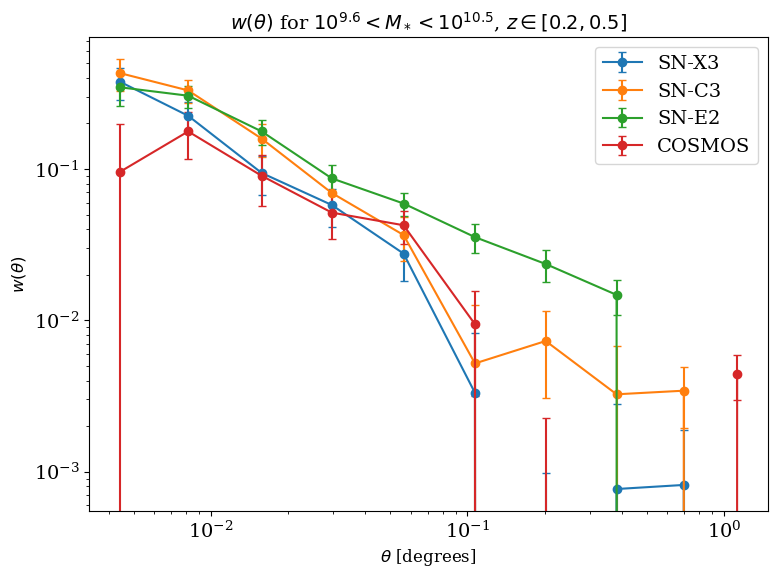

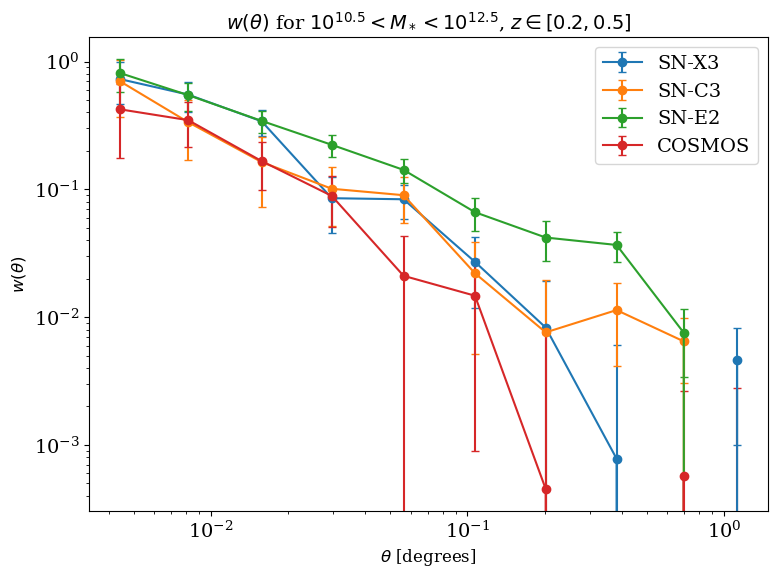

In [94]:
for (SM_min, SM_max), result in all_results.items():
    estimator = result['estimator']
    fig, ax = plt.subplots(figsize=(8, 6))
    
    for field_data in estimator.fields:
        #theta = first_results['theta']
        results = subsample.get_results()
        theta = results['theta']
        w_theta = field_data['w_theta']
        w_theta_err = field_data['w_error']
        
        #ax.scatter(theta, w_theta, label=field_data['name'])
        ax.errorbar(theta, w_theta, yerr=w_theta_err, fmt='o-', label=field_data['name'], capsize=3)

    
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel(r'$\theta$ [degrees]', fontsize=12)
    ax.set_ylabel(r'$w(\theta)$', fontsize=12)
    ax.set_title(f'$w(\\theta)$ for $10^{{{SM_min}}} < M_* < 10^{{{SM_max}}}$, $z \in [{z_min},{z_max}]$', fontsize=14)
    ax.legend()
    #ax.grid(True, which="both", ls="--", alpha=0.5)
    plt.tight_layout()
    #plt.savefig(f"wtheta_SM_{SM_min}_{SM_max}.png")
    plt.show()


In [55]:
shuntov_data = {
    (10.5, 12.5): {
        "theta": np.array([
            8.6213e-04, 1.8266e-03, 3.8500e-03, 8.4446e-03,
            1.9095e-02, 4.1869e-02, 9.3389e-02, 2.0352e-01,
            4.3985e-01, 8.6697e-01
        ]),
        "wtheta": np.array([
            4.0512, 2.1335, 0.76826, 0.60844,
            0.23972, 0.064465, 0.021901, 0.0086372,
            0.0026260, -0.0046342
        ]),
        "error": np.array([
            1.4703, 0.58440, 0.19946, 0.11059,
            0.10579, 0.051982, 0.018514, 0.012101,
            0.0047944, 0.0036775
        ])
    },
    (9.6, 10.5): {
        "theta": np.array([
            8.6177e-04, 1.8088e-03, 3.9387e-03, 8.6512e-03,
            1.9151e-02, 4.2155e-02, 9.3135e-02, 2.0382e-01,
            4.4044e-01, 8.6983e-01
        ]),
        "wtheta": np.array([
            2.4589, 1.4099, 0.66725, 0.40769,
            0.18806, 0.072816, 0.011834, 0.0077454,
            0.0029769, -0.0041483
        ]),
        "error": np.array([
            0.35086, 0.11457, 0.070194, 0.052862,
            0.046929, 0.022189, 0.0089981, 0.0070251,
            0.0029207, 0.0022315
        ])
    },
    (9.0, 9.6): {
        "theta": np.array([
            8.3259e-04, 1.8063e-03, 3.9674e-03, 8.7145e-03,
            1.9194e-02, 4.2263e-02, 9.3085e-02, 2.0379e-01,
            4.4007e-01, 8.6861e-01
        ]),
        "wtheta": np.array([
            1.2910, 0.97706, 0.52575, 0.33105,
            0.15498, 0.061639, 0.012956, 0.0081038,
            0.0026256, -0.0043871
        ]),
        "error": np.array([
            0.16438, 0.080514, 0.037668, 0.037046,
            0.029617, 0.016203, 0.0084722, 0.0077168,
            0.0032781, 0.0026839
        ])
    },
    (8.6, 9.0): {
        "theta": np.array([
            8.4966e-04, 1.8031e-03, 3.9695e-03, 8.7495e-03,
            1.9216e-02, 4.2306e-02, 9.3108e-02, 2.0376e-01,
            4.4003e-01, 8.6822e-01
        ]),
        "wtheta": np.array([
            0.86374, 0.76856, 0.43005, 0.26244,
            0.13492, 0.050636, 0.012632, 0.0066597,
            0.0023886, -0.0037334
        ]),
        "error": np.array([
            0.098497, 0.043001, 0.033822, 0.023979,
            0.019220, 0.011188, 0.0070628, 0.0067357,
            0.0029484, 0.0024237
        ])
    },
    (8.17, 8.6): {
        "theta": np.array([
            8.4620e-04, 1.8016e-03, 3.9815e-03, 8.7588e-03,
            1.9257e-02, 4.2327e-02, 9.3100e-02, 2.0381e-01,
            4.4014e-01, 8.6768e-01
        ]),
        "wtheta": np.array([
            0.60852, 0.56341, 0.32357, 0.19411,
            0.10953, 0.040942, 0.012872, 0.0058622,
            0.0021337, -0.0033312
        ]),
        "error": np.array([
            0.057764, 0.029369, 0.022334, 0.019434,
            0.014293, 0.0085523, 0.0054175, 0.0060078,
            0.0021963, 0.0020317
        ])
    }
}


<>:31: SyntaxWarning: invalid escape sequence '\i'
<>:31: SyntaxWarning: invalid escape sequence '\i'
/tmp/ipykernel_1369813/3612223487.py:31: SyntaxWarning: invalid escape sequence '\i'
  ax.set_title(f'$w(\\theta)$ for $10^{{{SM_min}}} < M_* < 10^{{{SM_max}}}$,$z \in [{z_min},{z_max}]$', fontsize=14)


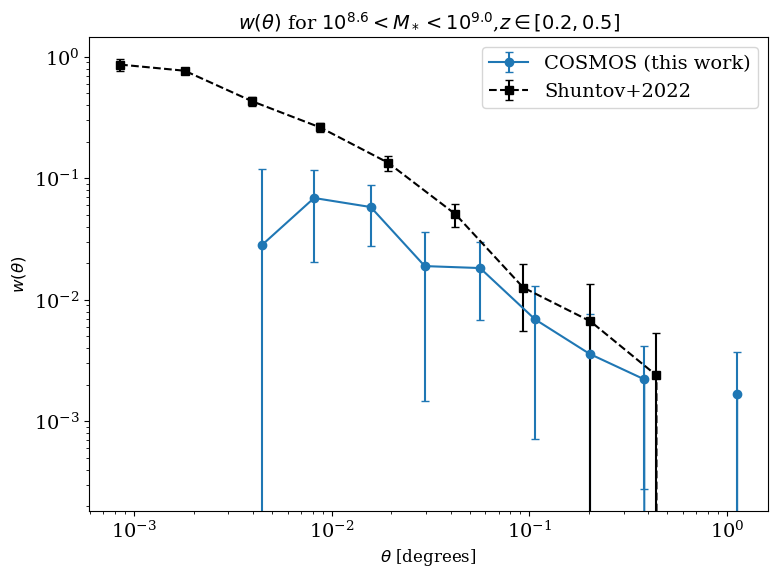

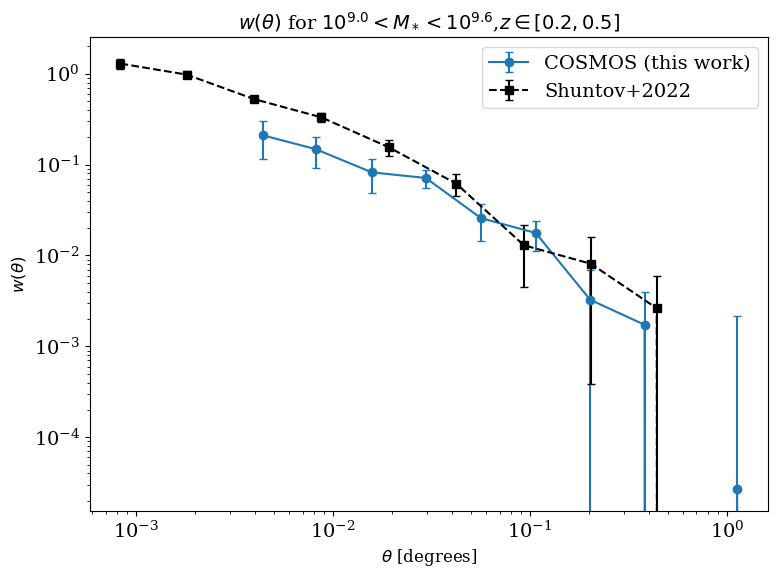

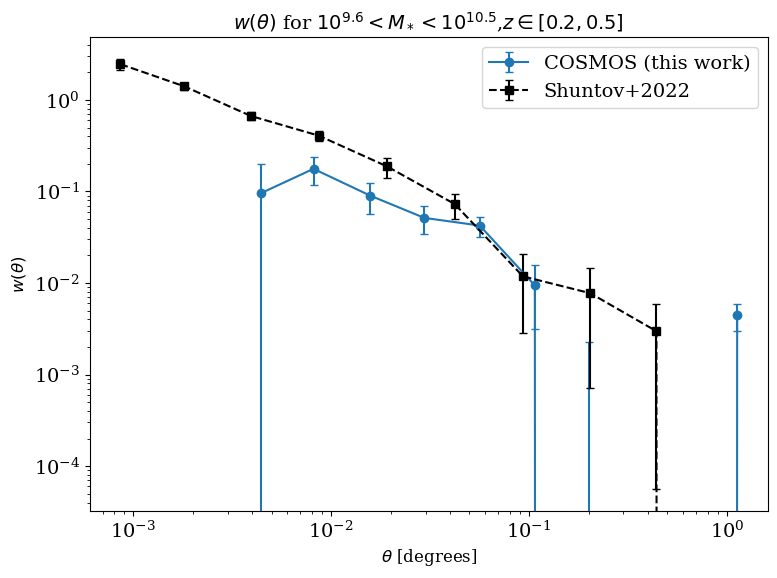

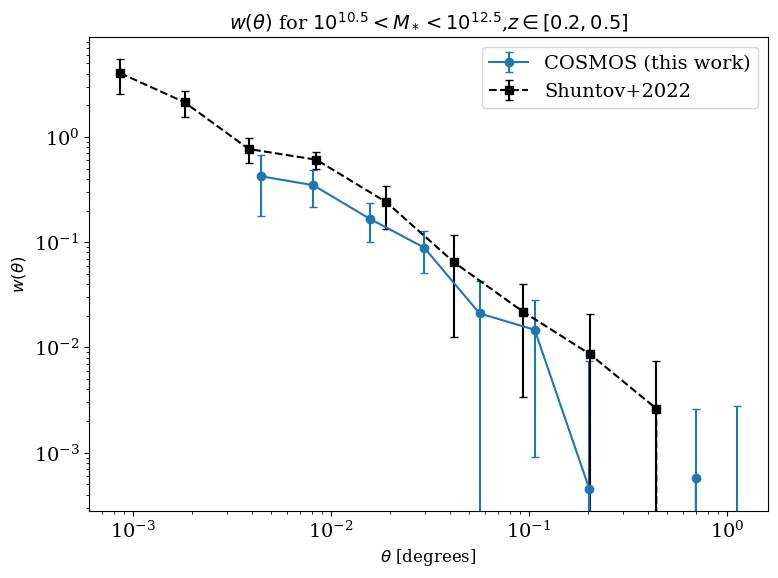

In [56]:
for (SM_min, SM_max), result in all_results.items():
    estimator = result['estimator']
    fig, ax = plt.subplots(figsize=(8, 6))

    # Plot my data
    for field_data in estimator.fields:
        if field_data['name'] != 'COSMOS':
            continue

       # theta = config['min_sep'] * (10 ** (np.arange(len(field_data['w_theta'])) * config['bin_size']))
        results = subsample.get_results()
        theta = results['theta']

        w_theta = field_data['w_theta']
        w_theta_err = field_data['w_error']

        ax.errorbar(theta, w_theta, yerr=w_theta_err, fmt='o-', capsize=3,  label='COSMOS (this work)')

    # Plot Shuntov data 
    if (SM_min, SM_max) in shuntov_data:
        sd = shuntov_data[(SM_min, SM_max)]
        ax.errorbar(
            sd['theta'], sd['wtheta'], yerr=sd['error'],
            fmt='s--', color='black', capsize=3, label='Shuntov+2022'
        )

    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel(r'$\theta$ [degrees]', fontsize=12)
    ax.set_ylabel(r'$w(\theta)$', fontsize=12)
    ax.set_title(f'$w(\\theta)$ for $10^{{{SM_min}}} < M_* < 10^{{{SM_max}}}$,$z \in [{z_min},{z_max}]$', fontsize=14)
    ax.legend()
    #ax.grid(True, which="both", ls="--", alpha=0.5)
    plt.tight_layout()
    plt.savefig(f"wtheta_COSMOS_vs_Shuntov_SM_{SM_min}_{SM_max}.png")
    plt.show()

In [124]:


# Now loop over stellar mass bins
for (SM_min, SM_max), result in all_results.items():
    estimator = result['estimator']
    fig, ax = plt.subplots(figsize=(8, 6))

    # Plot COSMOS data
    for field_data in estimator.fields:
        if field_data['name'] != 'COSMOS':
            continue

        results = subsample.get_results()
        theta = results['theta']  # Use this for plotting both data and model
        w_model = field_data.hod_model(logM_min * 1e7, logM_1, alpha)

        
        w_theta = field_data['w_theta']
        w_theta_err = field_data['w_error']

        ax.errorbar(theta, w_theta, yerr=w_theta_err, fmt='o-', capsize=3, label='COSMOS (this work)')

        # Overlay the HOD model
        ax.plot(theta, w_model, label='Best-fit HOD Model', color='red', lw=2)

    # Plot Shuntov+2022 data if available
    if (SM_min, SM_max) in shuntov_data:
        sd = shuntov_data[(SM_min, SM_max)]
        ax.errorbar(
            sd['theta'], sd['wtheta'], yerr=sd['error'],
            fmt='s--', color='black', capsize=3, label='Shuntov+2022'
        )

    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel(r'$\theta$ [degrees]', fontsize=12)
    ax.set_ylabel(r'$w(\theta)$', fontsize=12)
    ax.set_title(f'$w(\\theta)$ for $10^{{{SM_min}}} < M_* < 10^{{{SM_max}}}$, $z \\in [{z_min},{z_max}]$', fontsize=14)
    ax.legend()
    plt.tight_layout()
    plt.savefig(f"wtheta_COSMOS_vs_Shuntov_SM_{SM_min}_{SM_max}.png")
    plt.show()


AttributeError: 'dict' object has no attribute 'hod_model'

/tmp/ipykernel_1369813/1367183447.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('viridis', len(all_results))  # discrete colors matching number of bins


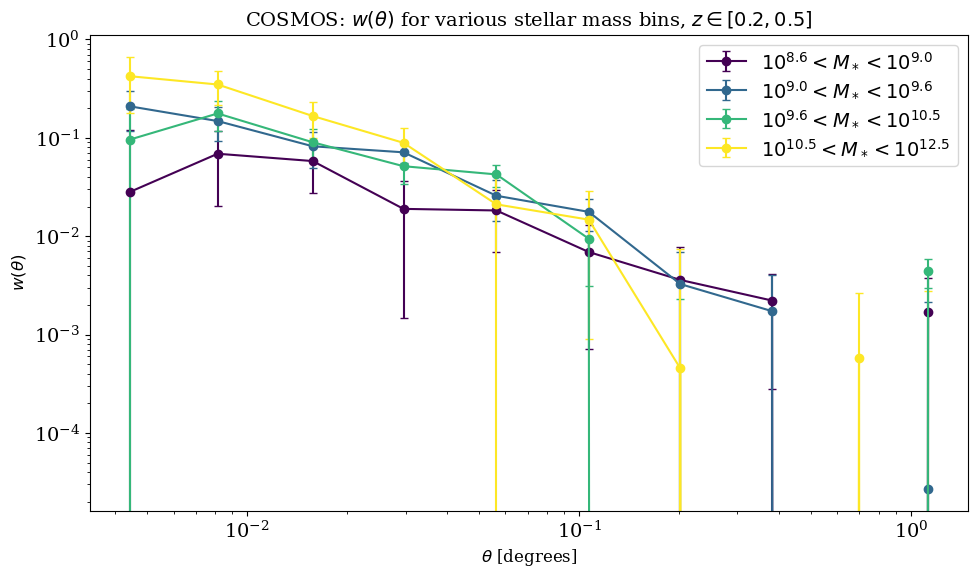

In [82]:
fig, ax = plt.subplots(figsize=(10, 6))

# Use viridis colormap
colors = cm.get_cmap('viridis', len(all_results))  # discrete colors matching number of bins

for i, ((SM_min, SM_max), result) in enumerate(all_results.items()):
    estimator = result['estimator']

    for field_data in estimator.fields:
        if field_data['name'] != 'COSMOS':
            continue
        
        results = subsample.get_results()
        theta = results['theta']

        w_theta = field_data['w_theta']
        w_theta_err = field_data['w_error']

        color = colors(i)  # get color from viridis colormap

        label = f'$10^{{{SM_min}}} < M_* < 10^{{{SM_max}}}$'

        ax.errorbar(theta, w_theta, yerr=w_theta_err, fmt='o-', capsize=3,
                    label=label, color=color)

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$\theta$ [degrees]', fontsize=12)
ax.set_ylabel(r'$w(\theta)$', fontsize=12)
ax.set_title(r'COSMOS: $w(\theta)$ for various stellar mass bins, $z \in [{}, {}]$'.format(z_min, z_max), fontsize=14)

ax.legend()
plt.tight_layout()
plt.show()


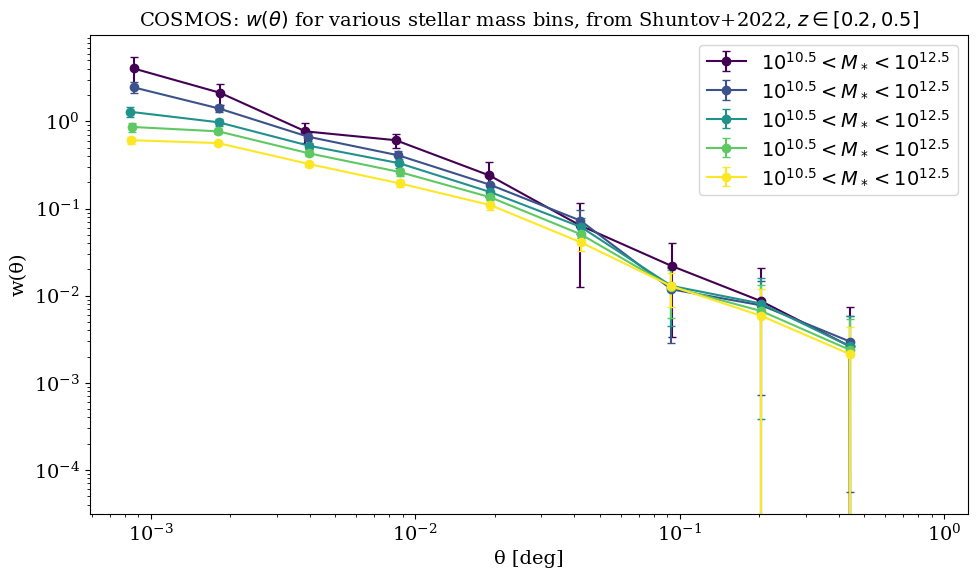

In [84]:
fig, ax = plt.subplots(figsize=(10, 6))
colors = plt.cm.viridis(np.linspace(0, 1, len(shuntov_data)))

for (mass_range, color) in zip(shuntov_data, colors):
    data = shuntov_data[mass_range]
    label = f'$10^{{{SM_min}}} < M_* < 10^{{{SM_max}}}$'
    ax.errorbar(data["theta"], data["wtheta"], yerr=data["error"],
                 fmt='o-',  label=label, color=color, capsize=3)

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel("θ [deg]")
ax.set_ylabel("w(θ)")
ax.set_title(r'COSMOS: $w(\theta)$ for various stellar mass bins, from Shuntov+2022, $z \in [{}, {}]$'.format(z_min, z_max), fontsize=14)

ax.legend()

plt.tight_layout()
plt.show()


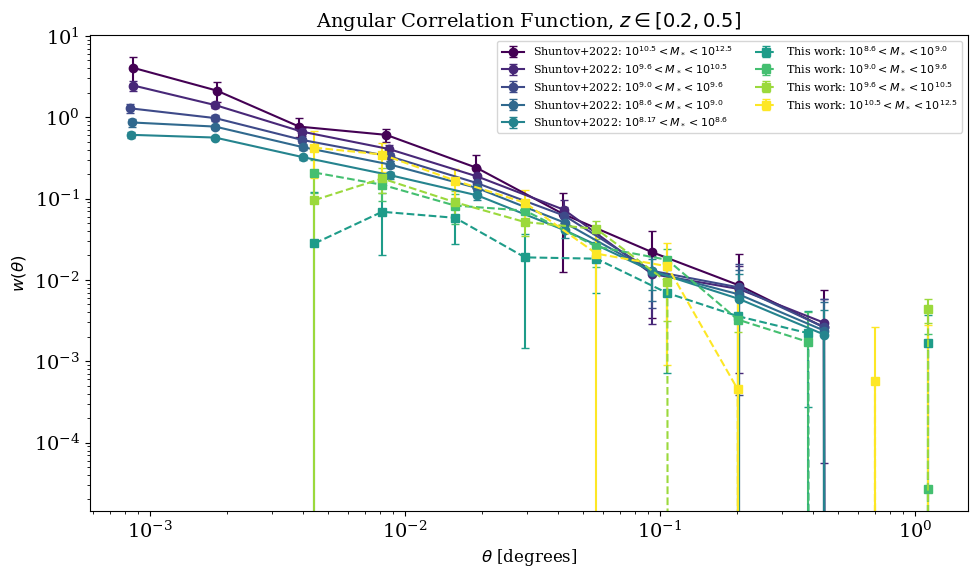

In [91]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm

fig, ax = plt.subplots(figsize=(10, 6))

# Viridis colors for Shuntov data
shuntov_colors = plt.cm.viridis(np.linspace(0, 0.45, len(shuntov_data)))
# Viridis colors for COSMOS data, use upper half of colormap for distinction
cosmos_colors = plt.cm.viridis(np.linspace(0.55, 1, len(all_results)))

# Plot Shuntov data first
for color, (mass_range) in zip(shuntov_colors, shuntov_data):
    data = shuntov_data[mass_range]
    label = f'Shuntov+2022: $10^{{{mass_range[0]}}} < M_* < 10^{{{mass_range[1]}}}$'
    ax.errorbar(data["theta"], data["wtheta"], yerr=data["error"],
                fmt='o-', label=label, color=color, capsize=3)

# Plot COSMOS data
for i, ((SM_min, SM_max), result) in enumerate(all_results.items()):
    estimator = result['estimator']

    for field_data in estimator.fields:
        if field_data['name'] != 'COSMOS':
            continue

        results = subsample.get_results()
        theta = results['theta']

        w_theta = field_data['w_theta']
        w_theta_err = field_data['w_error']

        color = cosmos_colors[i]

        label = f'This work: $10^{{{SM_min}}} < M_* < 10^{{{SM_max}}}$'

        ax.errorbar(theta, w_theta, yerr=w_theta_err, fmt='s--', capsize=3,
                    label=label, color=color)

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$\theta$ [degrees]', fontsize=12)
ax.set_ylabel(r'$w(\theta)$', fontsize=12)
ax.set_title(r'Angular Correlation Function, $z \in [{}, {}]$'.format(z_min, z_max), fontsize=14)

ax.legend(fontsize=8, loc='best', ncol=2)
plt.tight_layout()
plt.show()


<>:31: SyntaxWarning: invalid escape sequence '\i'
<>:31: SyntaxWarning: invalid escape sequence '\i'
/tmp/ipykernel_1369813/1853499069.py:31: SyntaxWarning: invalid escape sequence '\i'
  ax.set_title(f'$w(\\theta)$ for $10^{{{SM_min}}} < M_* < 10^{{{SM_max}}}$,$z \in [{z_min},{z_max}]$', fontsize=14)


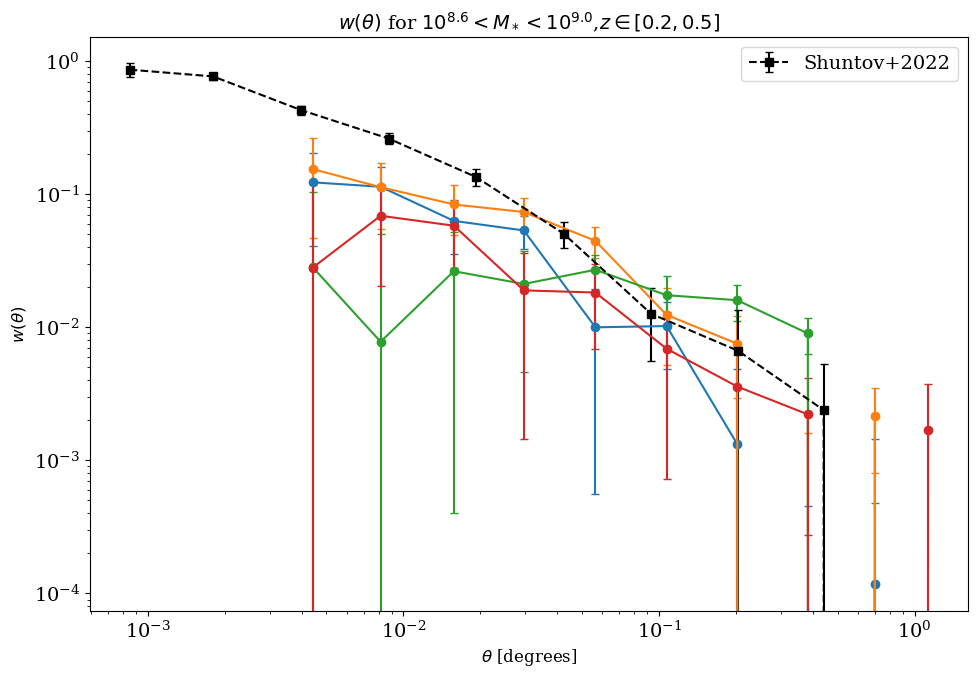

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [88]:
fig, ax = plt.subplots(figsize=(10, 7))

for (SM_min, SM_max), result in all_results.items():
    estimator = result['estimator']

    # Plot my data
    for field_data in estimator.fields:


       # theta = config['min_sep'] * (10 ** (np.arange(len(field_data['w_theta'])) * config['bin_size']))
        results = subsample.get_results()
        theta = results['theta']

        w_theta = field_data['w_theta']
        w_theta_err = field_data['w_error']

        ax.errorbar(theta, w_theta, yerr=w_theta_err, fmt='o-', capsize=3)

    # Plot Shuntov data 
    if (SM_min, SM_max) in shuntov_data:
        sd = shuntov_data[(SM_min, SM_max)]
        ax.errorbar(
            sd['theta'], sd['wtheta'], yerr=sd['error'],
            fmt='s--', color='black', capsize=3, label='Shuntov+2022'
        )

    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel(r'$\theta$ [degrees]', fontsize=12)
    ax.set_ylabel(r'$w(\theta)$', fontsize=12)
    ax.set_title(f'$w(\\theta)$ for $10^{{{SM_min}}} < M_* < 10^{{{SM_max}}}$,$z \in [{z_min},{z_max}]$', fontsize=14)
    ax.legend()
    #ax.grid(True, which="both", ls="--", alpha=0.5)
    plt.tight_layout()
    plt.savefig(f"wtheta_COSMOS_vs_Shuntov_SM_{SM_min}_{SM_max}.png")
    plt.show()

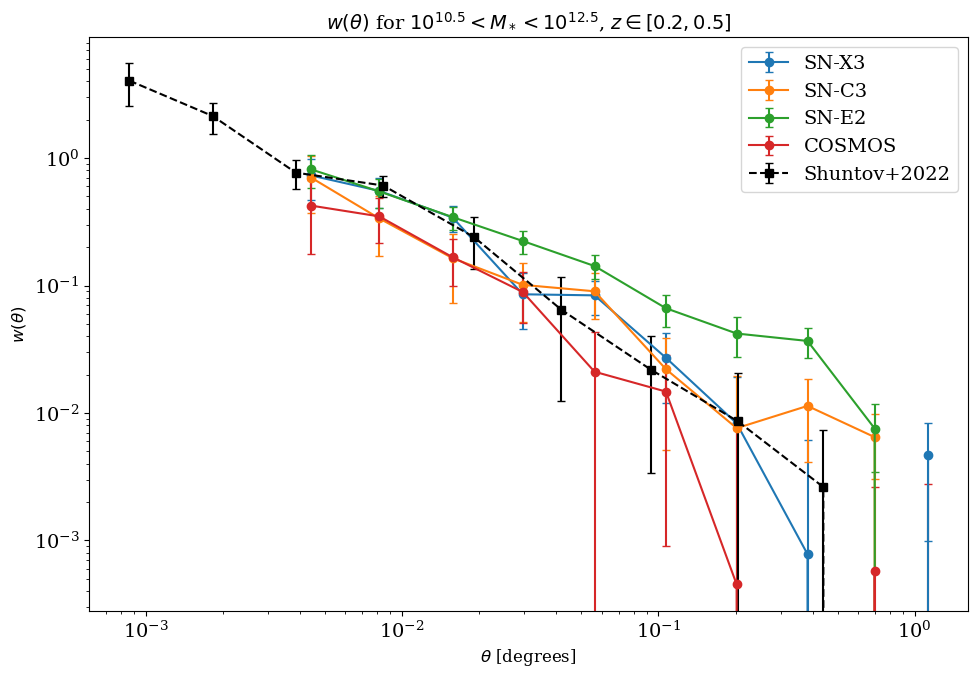

In [95]:
import matplotlib.pyplot as plt

# Find the stellar mass bin with the highest SM_min
highest_bin = max(all_results.keys(), key=lambda x: x[0])
SM_min, SM_max = highest_bin

fig, ax = plt.subplots(figsize=(10, 7))

result = all_results[highest_bin]
estimator = result['estimator']

# Plot COSMOS data for that bin
for field_data in estimator.fields:


    results = subsample.get_results()
    theta = results['theta']

    w_theta = field_data['w_theta']
    w_theta_err = field_data['w_error']

    ax.errorbar(theta, w_theta, yerr=w_theta_err, fmt='o-', capsize=3, label=field_data['name'])

# Plot Shuntov data if available
if highest_bin in shuntov_data:
    sd = shuntov_data[highest_bin]
    ax.errorbar(sd['theta'], sd['wtheta'], yerr=sd['error'], fmt='s--', color='black',
                capsize=3, label='Shuntov+2022')

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$\theta$ [degrees]', fontsize=12)
ax.set_ylabel(r'$w(\theta)$', fontsize=12)
ax.set_title(f'$w(\\theta)$ for $10^{{{SM_min}}} < M_* < 10^{{{SM_max}}}$, $z \\in [{z_min}, {z_max}]$', fontsize=14)
ax.legend()
plt.tight_layout()
plt.savefig(f"wtheta_COSMOS_vs_Shuntov_SM_{SM_min}_{SM_max}.png")
plt.show()
